In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:51:47.827559
File: machine_learning_experiment04
Experiment Number: 4


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 1029933563


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment04.ipynb' is assigned to device: cuda:2 with seed 1029933563.


Experiment number: 4 | Seed number: 1029933563
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:51:48,624] A new study created in memory with name: no-name-38cdf795-88cd-4836-84ba-e4a1a98e950f


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:51:51,387] Trial 0 finished with value: 0.697215716887848 and parameters: {'threshold': '0.5*mean', 'max_features': 350, 'norm_order': 1, 'learning_rate': 0.06812589287336009, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5814621444805488, 'colsample_bytree': 0.6206571343332717, 'gamma': 7.283484631154344, 'reg_alpha': 4.618098356884551, 'reg_lambda': 7.0082489142274085, 'n_estimators': 240}. Best is trial 0 with value: 0.697215716887848.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:51:53,447] Trial 1 finished with value: 0.6998341625207297 and parameters: {'threshold': '1.5*mean', 'max_features': 515, 'norm_order': 1, 'learning_rate': 0.06373795582441284, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8569390377492637, 'colsample_bytree': 0.8294199986487022, 'gamma': 6.648707615262629, 'reg_alpha': 9.374963751958942, 'reg_lambda': 9.627139075751197, 'n_estimators': 96}. Best is trial 1 with value: 0.6998341625207297.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:51:55,135] Trial 2 finished with value: 0.7279400172322132 and parameters: {'threshold': 'median', 'max_features': 122, 'norm_order': 2, 'learning_rate': 0.15117495993484106, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5873680306281893, 'colsample_bytree': 0.8297010679820513, 'gamma': 9.22090830597448, 'reg_alpha': 1.907009588644425, 'reg_lambda': 1.4757328287827098, 'n_estimators': 179}. Best is trial 2 with value: 0.7279400172322132.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:51:57,838] Trial 3 finished with value: 0.7063107573366271 and parameters: {'threshold': 'mean', 'max_features': 614, 'norm_order': 2, 'learning_rate': 0.24995748226862238, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8649210887667351, 'colsample_bytree': 0.7019400716806035, 'gamma': 6.725866436247347, 'reg_alpha': 6.083237454125012, 'reg_lambda': 8.27819254422516, 'n_estimators': 217}. Best is trial 2 with value: 0.7279400172322132.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:00,471] Trial 4 finished with value: 0.7524376183678098 and parameters: {'threshold': '1.5*mean', 'max_features': 443, 'norm_order': 2, 'learning_rate': 0.03396285921687884, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.8265282852723876, 'colsample_bytree': 0.6814142040508623, 'gamma': 6.15212287773395, 'reg_alpha': 7.282779257655511, 'reg_lambda': 7.409913693095368, 'n_estimators': 127}. Best is trial 4 with value: 0.7524376183678098.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:02,218] Trial 5 finished with value: 0.7550607014993673 and parameters: {'threshold': '0.5*mean', 'max_features': 335, 'norm_order': 1, 'learning_rate': 0.3446038009111405, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.9873126411822088, 'colsample_bytree': 0.8840456873706928, 'gamma': 2.6273281267664625, 'reg_alpha': 9.82495419640951, 'reg_lambda': 4.4868446204200225, 'n_estimators': 77}. Best is trial 5 with value: 0.7550607014993673.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:05,100] Trial 6 finished with value: 0.7125644571198109 and parameters: {'threshold': 'median', 'max_features': 888, 'norm_order': 1, 'learning_rate': 0.19443929356165765, 'max_depth': 27, 'min_child_weight': 8, 'subsample': 0.5776143582220494, 'colsample_bytree': 0.7475898692433689, 'gamma': 6.748652722322971, 'reg_alpha': 2.2820600680275502, 'reg_lambda': 6.949403102849274, 'n_estimators': 270}. Best is trial 5 with value: 0.7550607014993673.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:07,526] Trial 7 finished with value: 0.7242445054945055 and parameters: {'threshold': '0.5*mean', 'max_features': 252, 'norm_order': 2, 'learning_rate': 0.47053948208974056, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.8314002441082322, 'colsample_bytree': 0.7299531097952081, 'gamma': 9.666474993683137, 'reg_alpha': 3.286239890299274, 'reg_lambda': 5.535272922279789, 'n_estimators': 270}. Best is trial 5 with value: 0.7550607014993673.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:10,448] Trial 8 finished with value: 0.6856801390699695 and parameters: {'threshold': '1.5*mean', 'max_features': 829, 'norm_order': 1, 'learning_rate': 0.25039324848532407, 'max_depth': 19, 'min_child_weight': 9, 'subsample': 0.6595345744471433, 'colsample_bytree': 0.9504165709048598, 'gamma': 4.815088157685363, 'reg_alpha': 7.433387987943124, 'reg_lambda': 2.11927734120533, 'n_estimators': 177}. Best is trial 5 with value: 0.7550607014993673.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:13,430] Trial 9 finished with value: 0.6036361063950197 and parameters: {'threshold': '1.5*mean', 'max_features': 373, 'norm_order': 2, 'learning_rate': 0.0207731582902189, 'max_depth': 29, 'min_child_weight': 6, 'subsample': 0.994442069109224, 'colsample_bytree': 0.7545158494897916, 'gamma': 9.47943052737131, 'reg_alpha': 9.80285215908083, 'reg_lambda': 8.57116475424531, 'n_estimators': 168}. Best is trial 5 with value: 0.7550607014993673.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:15,999] Trial 10 finished with value: 0.7742519534972366 and parameters: {'threshold': 'very_low', 'max_features': 24, 'norm_order': 1, 'learning_rate': 0.40636508165911744, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.9686894413853884, 'colsample_bytree': 0.988040937150198, 'gamma': 1.2116520599666147, 'reg_alpha': 0.5384421039893379, 'reg_lambda': 3.96634312017639, 'n_estimators': 60}. Best is trial 10 with value: 0.7742519534972366.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:18,685] Trial 11 finished with value: 0.7518547544409614 and parameters: {'threshold': 'very_low', 'max_features': 32, 'norm_order': 1, 'learning_rate': 0.3897305220342777, 'max_depth': 13, 'min_child_weight': 5, 'subsample': 0.9911972972125316, 'colsample_bytree': 0.980833474979699, 'gamma': 1.3093747854724427, 'reg_alpha': 0.023192069714558783, 'reg_lambda': 3.610174340727781, 'n_estimators': 50}. Best is trial 10 with value: 0.7742519534972366.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:21,801] Trial 12 finished with value: 0.7378860794948183 and parameters: {'threshold': 'very_low', 'max_features': 180, 'norm_order': 1, 'learning_rate': 0.3601026835285156, 'max_depth': 11, 'min_child_weight': 10, 'subsample': 0.9330252723687331, 'colsample_bytree': 0.8942383145958213, 'gamma': 1.1078398207998634, 'reg_alpha': 0.2680368100709396, 'reg_lambda': 4.256133060540809, 'n_estimators': 62}. Best is trial 10 with value: 0.7742519534972366.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:24,701] Trial 13 finished with value: 0.6265379357484621 and parameters: {'threshold': 'very_low', 'max_features': 6, 'norm_order': 1, 'learning_rate': 0.3590633377185035, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.747706276147668, 'colsample_bytree': 0.526387567794597, 'gamma': 2.9333999939632798, 'reg_alpha': 4.639830772944346, 'reg_lambda': 2.972631086097392, 'n_estimators': 104}. Best is trial 10 with value: 0.7742519534972366.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:27,717] Trial 14 finished with value: 0.7280904280904282 and parameters: {'threshold': '0.5*mean', 'max_features': 654, 'norm_order': 1, 'learning_rate': 0.48685233858273247, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9193779373650186, 'colsample_bytree': 0.900310434678264, 'gamma': 3.1203351408247038, 'reg_alpha': 8.216620778308645, 'reg_lambda': 0.08528148528816537, 'n_estimators': 86}. Best is trial 10 with value: 0.7742519534972366.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:31,034] Trial 15 finished with value: 0.8049825991002462 and parameters: {'threshold': 'mean', 'max_features': 247, 'norm_order': 1, 'learning_rate': 0.4016208444562685, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.7440904930045728, 'colsample_bytree': 0.9981643965079701, 'gamma': 0.18751059300850725, 'reg_alpha': 5.829665513478226, 'reg_lambda': 5.336926516189947, 'n_estimators': 130}. Best is trial 15 with value: 0.8049825991002462.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:34,571] Trial 16 finished with value: 0.7798742138364781 and parameters: {'threshold': 'mean', 'max_features': 162, 'norm_order': 1, 'learning_rate': 0.42181200600787633, 'max_depth': 23, 'min_child_weight': 3, 'subsample': 0.7256088163392106, 'colsample_bytree': 0.9913642289857546, 'gamma': 0.22287769883119707, 'reg_alpha': 3.450729233612788, 'reg_lambda': 5.661472348960646, 'n_estimators': 134}. Best is trial 15 with value: 0.8049825991002462.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:38,284] Trial 17 finished with value: 0.8175350491734671 and parameters: {'threshold': 'mean', 'max_features': 222, 'norm_order': 1, 'learning_rate': 0.4356209805340741, 'max_depth': 24, 'min_child_weight': 3, 'subsample': 0.7292364247552922, 'colsample_bytree': 0.9470685276201671, 'gamma': 0.6954016754964009, 'reg_alpha': 5.380355092503466, 'reg_lambda': 5.535280012561333, 'n_estimators': 139}. Best is trial 17 with value: 0.8175350491734671.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:41,600] Trial 18 finished with value: 0.7912330855727082 and parameters: {'threshold': 'mean', 'max_features': 259, 'norm_order': 1, 'learning_rate': 0.3020338777669487, 'max_depth': 23, 'min_child_weight': 3, 'subsample': 0.5002076257157497, 'colsample_bytree': 0.8342386477565037, 'gamma': 0.10017498300895876, 'reg_alpha': 5.950532367100281, 'reg_lambda': 5.573929553009283, 'n_estimators': 142}. Best is trial 17 with value: 0.8175350491734671.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:45,189] Trial 19 finished with value: 0.7407886231415644 and parameters: {'threshold': 'mean', 'max_features': 545, 'norm_order': 1, 'learning_rate': 0.46561915430572337, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.6933554263434474, 'colsample_bytree': 0.9277125227555967, 'gamma': 4.138243791863243, 'reg_alpha': 6.030291125746947, 'reg_lambda': 6.27995044827539, 'n_estimators': 210}. Best is trial 17 with value: 0.8175350491734671.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:48,155] Trial 20 finished with value: 0.7334395164583846 and parameters: {'threshold': 'mean', 'max_features': 694, 'norm_order': 2, 'learning_rate': 0.4351767314778806, 'max_depth': 25, 'min_child_weight': 4, 'subsample': 0.7898921179000715, 'colsample_bytree': 0.8632968720083625, 'gamma': 1.7267118569296227, 'reg_alpha': 5.267499965955897, 'reg_lambda': 2.8469284060027693, 'n_estimators': 150}. Best is trial 17 with value: 0.8175350491734671.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:51,725] Trial 21 finished with value: 0.8088665934577884 and parameters: {'threshold': 'mean', 'max_features': 259, 'norm_order': 1, 'learning_rate': 0.31776026796911816, 'max_depth': 22, 'min_child_weight': 3, 'subsample': 0.5012967846563849, 'colsample_bytree': 0.8154590922053547, 'gamma': 0.09170557066206862, 'reg_alpha': 6.360070073293894, 'reg_lambda': 5.0898204324655065, 'n_estimators': 115}. Best is trial 17 with value: 0.8175350491734671.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:55,538] Trial 22 finished with value: 0.8212466545799879 and parameters: {'threshold': 'mean', 'max_features': 266, 'norm_order': 1, 'learning_rate': 0.298207559443272, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6717096659305232, 'colsample_bytree': 0.7842730814590821, 'gamma': 0.0852566712647298, 'reg_alpha': 6.930441574730786, 'reg_lambda': 4.898724974306117, 'n_estimators': 116}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:52:58,411] Trial 23 finished with value: 0.7451370468611849 and parameters: {'threshold': 'mean', 'max_features': 1009, 'norm_order': 1, 'learning_rate': 0.30043404953685, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.643064921060603, 'colsample_bytree': 0.8048247793231571, 'gamma': 2.016993549485681, 'reg_alpha': 6.886419605619449, 'reg_lambda': 6.390773812098908, 'n_estimators': 113}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:02,221] Trial 24 finished with value: 0.7863802863802863 and parameters: {'threshold': 'mean', 'max_features': 444, 'norm_order': 1, 'learning_rate': 0.3006198397903953, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.6268647866725641, 'colsample_bytree': 0.7785155272593206, 'gamma': 0.8638925605244783, 'reg_alpha': 8.254667349632133, 'reg_lambda': 4.773278712180748, 'n_estimators': 158}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:05,374] Trial 25 finished with value: 0.7429917386057737 and parameters: {'threshold': 'mean', 'max_features': 117, 'norm_order': 1, 'learning_rate': 0.19848409604131562, 'max_depth': 26, 'min_child_weight': 4, 'subsample': 0.508714364047851, 'colsample_bytree': 0.6440583031646823, 'gamma': 3.704538938698851, 'reg_alpha': 4.046588856442424, 'reg_lambda': 7.801785224233002, 'n_estimators': 116}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:08,391] Trial 26 finished with value: 0.7689128481581312 and parameters: {'threshold': 'mean', 'max_features': 305, 'norm_order': 1, 'learning_rate': 0.32407786381294035, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.6956903354792787, 'colsample_bytree': 0.9313813261321563, 'gamma': 2.0538404735052005, 'reg_alpha': 8.272447365533509, 'reg_lambda': 3.3972504564182033, 'n_estimators': 191}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:11,747] Trial 27 finished with value: 0.7345911949685536 and parameters: {'threshold': 'mean', 'max_features': 444, 'norm_order': 1, 'learning_rate': 0.21200293893314276, 'max_depth': 24, 'min_child_weight': 4, 'subsample': 0.5424413544634278, 'colsample_bytree': 0.7710441302145445, 'gamma': 0.5566023138649455, 'reg_alpha': 6.6905812596379715, 'reg_lambda': 6.222737566207295, 'n_estimators': 80}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:14,574] Trial 28 finished with value: 0.7377220480668756 and parameters: {'threshold': 'median', 'max_features': 189, 'norm_order': 1, 'learning_rate': 0.13796907921150722, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.7731863706060079, 'colsample_bytree': 0.556812106595607, 'gamma': 2.421048555777556, 'reg_alpha': 5.2990039687687664, 'reg_lambda': 4.953300725495457, 'n_estimators': 116}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:17,685] Trial 29 finished with value: 0.6923105143444127 and parameters: {'threshold': 'mean', 'max_features': 369, 'norm_order': 1, 'learning_rate': 0.4453074273396141, 'max_depth': 21, 'min_child_weight': 6, 'subsample': 0.610271565980388, 'colsample_bytree': 0.6060675802205173, 'gamma': 8.563932737301396, 'reg_alpha': 3.935713923508845, 'reg_lambda': 6.875295800288201, 'n_estimators': 156}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:21,141] Trial 30 finished with value: 0.7136752136752137 and parameters: {'threshold': 'mean', 'max_features': 116, 'norm_order': 1, 'learning_rate': 0.27390333302110437, 'max_depth': 25, 'min_child_weight': 5, 'subsample': 0.6692757250225763, 'colsample_bytree': 0.8590939289561963, 'gamma': 1.432880360307201, 'reg_alpha': 8.867232093131777, 'reg_lambda': 1.2861241989531305, 'n_estimators': 192}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:24,162] Trial 31 finished with value: 0.8201198872518248 and parameters: {'threshold': 'mean', 'max_features': 257, 'norm_order': 1, 'learning_rate': 0.38805001410904394, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.722818043870985, 'colsample_bytree': 0.9483931334394785, 'gamma': 0.20639271673233867, 'reg_alpha': 5.721653128529356, 'reg_lambda': 5.56098994233538, 'n_estimators': 124}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:27,546] Trial 32 finished with value: 0.7977553310886645 and parameters: {'threshold': 'mean', 'max_features': 287, 'norm_order': 1, 'learning_rate': 0.38324952380689126, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.6948027816390506, 'colsample_bytree': 0.8054048682272148, 'gamma': 0.025728633090903813, 'reg_alpha': 6.669563823512548, 'reg_lambda': 4.818809226231439, 'n_estimators': 96}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:30,548] Trial 33 finished with value: 0.80688520519029 and parameters: {'threshold': 'mean', 'max_features': 206, 'norm_order': 1, 'learning_rate': 0.34304230217043713, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8003128332668704, 'colsample_bytree': 0.9561979245228436, 'gamma': 0.7860312755711951, 'reg_alpha': 4.665792900251242, 'reg_lambda': 6.081881757584318, 'n_estimators': 140}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:33,449] Trial 34 finished with value: 0.7945887445887445 and parameters: {'threshold': 'median', 'max_features': 98, 'norm_order': 1, 'learning_rate': 0.28031307068683575, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7198415050781962, 'colsample_bytree': 0.9209787324533918, 'gamma': 1.8334781607759245, 'reg_alpha': 5.411217206000697, 'reg_lambda': 4.067984269773798, 'n_estimators': 297}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:37,058] Trial 35 finished with value: 0.7388414055080722 and parameters: {'threshold': 'mean', 'max_features': 402, 'norm_order': 1, 'learning_rate': 0.3833959372993938, 'max_depth': 17, 'min_child_weight': 4, 'subsample': 0.5754268573766299, 'colsample_bytree': 0.6993801087268267, 'gamma': 0.8110500108942382, 'reg_alpha': 7.64281500298667, 'reg_lambda': 8.707274013888275, 'n_estimators': 99}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:40,658] Trial 36 finished with value: 0.6802748279297366 and parameters: {'threshold': 'mean', 'max_features': 558, 'norm_order': 2, 'learning_rate': 0.31695755093230826, 'max_depth': 21, 'min_child_weight': 3, 'subsample': 0.5395361866924699, 'colsample_bytree': 0.8214504097385306, 'gamma': 7.78006010342358, 'reg_alpha': 6.614608561116785, 'reg_lambda': 9.756130087519917, 'n_estimators': 123}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:44,083] Trial 37 finished with value: 0.7396460499908776 and parameters: {'threshold': '0.5*mean', 'max_features': 494, 'norm_order': 1, 'learning_rate': 0.15223877350602966, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8832749520521732, 'colsample_bytree': 0.8642884062153565, 'gamma': 5.841305582804362, 'reg_alpha': 5.697373162342016, 'reg_lambda': 7.124926440714235, 'n_estimators': 105}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:47,183] Trial 38 finished with value: 0.7737373737373737 and parameters: {'threshold': '1.5*mean', 'max_features': 330, 'norm_order': 1, 'learning_rate': 0.2359686859051922, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.7668118820395872, 'colsample_bytree': 0.6632731658295684, 'gamma': 0.5231348624287282, 'reg_alpha': 6.405546972961584, 'reg_lambda': 5.2656865392049355, 'n_estimators': 168}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:50,297] Trial 39 finished with value: 0.7395703062369728 and parameters: {'threshold': 'median', 'max_features': 72, 'norm_order': 2, 'learning_rate': 0.3627090126975079, 'max_depth': 27, 'min_child_weight': 3, 'subsample': 0.6086806596892816, 'colsample_bytree': 0.9493659537139914, 'gamma': 3.508703783086081, 'reg_alpha': 7.400652666513972, 'reg_lambda': 4.500976694297869, 'n_estimators': 90}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:53,508] Trial 40 finished with value: 0.741603928493974 and parameters: {'threshold': 'mean', 'max_features': 224, 'norm_order': 1, 'learning_rate': 0.45331639542024826, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.823951432318234, 'colsample_bytree': 0.7410246710622983, 'gamma': 5.191308971636257, 'reg_alpha': 4.9520715293499675, 'reg_lambda': 5.840231727781135, 'n_estimators': 145}. Best is trial 22 with value: 0.8212466545799879.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:56,488] Trial 41 finished with value: 0.8288563288563289 and parameters: {'threshold': 'mean', 'max_features': 162, 'norm_order': 1, 'learning_rate': 0.3362593500547089, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8195476091391452, 'colsample_bytree': 0.9616990842243038, 'gamma': 0.8159453889165564, 'reg_alpha': 4.287627328086712, 'reg_lambda': 6.053222166933523, 'n_estimators': 136}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:53:59,407] Trial 42 finished with value: 0.7702963785094751 and parameters: {'threshold': 'mean', 'max_features': 153, 'norm_order': 1, 'learning_rate': 0.496223223522002, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.8510985816681312, 'colsample_bytree': 0.9651388987553106, 'gamma': 1.5157326856228142, 'reg_alpha': 2.6346675244303253, 'reg_lambda': 6.623556331880303, 'n_estimators': 133}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:03,145] Trial 43 finished with value: 0.8028997762627063 and parameters: {'threshold': 'mean', 'max_features': 283, 'norm_order': 1, 'learning_rate': 0.3315332755819909, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7969633643462395, 'colsample_bytree': 0.8938951368651746, 'gamma': 0.5733049733858093, 'reg_alpha': 4.123527275627708, 'reg_lambda': 7.565276843958303, 'n_estimators': 125}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:06,084] Trial 44 finished with value: 0.7559845335349014 and parameters: {'threshold': '1.5*mean', 'max_features': 337, 'norm_order': 1, 'learning_rate': 0.41309301691311906, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.735628410887234, 'colsample_bytree': 0.9213596987626583, 'gamma': 2.4789650998628683, 'reg_alpha': 7.044851664589148, 'reg_lambda': 5.18235805961715, 'n_estimators': 164}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:09,166] Trial 45 finished with value: 0.7828872289656603 and parameters: {'threshold': 'mean', 'max_features': 60, 'norm_order': 1, 'learning_rate': 0.37334832269731616, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.7063149637162816, 'colsample_bytree': 0.8393798452813575, 'gamma': 1.148567900853894, 'reg_alpha': 1.2200239050981554, 'reg_lambda': 3.6485922232046217, 'n_estimators': 72}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:12,956] Trial 46 finished with value: 0.814279557977037 and parameters: {'threshold': '0.5*mean', 'max_features': 226, 'norm_order': 1, 'learning_rate': 0.2684308786559999, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6750877847373538, 'colsample_bytree': 0.7263817910939909, 'gamma': 0.046060735909538984, 'reg_alpha': 2.8890405439096973, 'reg_lambda': 5.807553549526613, 'n_estimators': 108}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:16,764] Trial 47 finished with value: 0.7829863563492866 and parameters: {'threshold': '0.5*mean', 'max_features': 153, 'norm_order': 1, 'learning_rate': 0.27315021408830653, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.6777049259892528, 'colsample_bytree': 0.7166304353506515, 'gamma': 1.1178230869366301, 'reg_alpha': 3.218714576862271, 'reg_lambda': 8.128612593216399, 'n_estimators': 150}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:20,739] Trial 48 finished with value: 0.8108061002178649 and parameters: {'threshold': '0.5*mean', 'max_features': 212, 'norm_order': 1, 'learning_rate': 0.22615588968208292, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.6583845098612062, 'colsample_bytree': 0.6063589140721601, 'gamma': 0.49876165267310896, 'reg_alpha': 2.6943277151479434, 'reg_lambda': 5.877159061035117, 'n_estimators': 108}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:24,241] Trial 49 finished with value: 0.7986704653371319 and parameters: {'threshold': '0.5*mean', 'max_features': 402, 'norm_order': 1, 'learning_rate': 0.3472751511081361, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.7617985659392695, 'colsample_bytree': 0.9779716756388914, 'gamma': 1.5516724082361928, 'reg_alpha': 1.2320927139222677, 'reg_lambda': 7.1997762989802325, 'n_estimators': 179}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:27,513] Trial 50 finished with value: 0.773435160227613 and parameters: {'threshold': 'very_low', 'max_features': 54, 'norm_order': 2, 'learning_rate': 0.25997789961008194, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.7158711265646481, 'colsample_bytree': 0.7759711514104793, 'gamma': 0.8810488624650561, 'reg_alpha': 4.399663809418718, 'reg_lambda': 4.397437283174339, 'n_estimators': 68}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:31,144] Trial 51 finished with value: 0.789425171778113 and parameters: {'threshold': '0.5*mean', 'max_features': 229, 'norm_order': 1, 'learning_rate': 0.1739771063612645, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6592502233109133, 'colsample_bytree': 0.5017701380697429, 'gamma': 0.4096016860068288, 'reg_alpha': 2.4146207873021615, 'reg_lambda': 5.87141112095981, 'n_estimators': 109}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:35,014] Trial 52 finished with value: 0.7654320987654321 and parameters: {'threshold': '0.5*mean', 'max_features': 204, 'norm_order': 1, 'learning_rate': 0.08741406720021436, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.6440838302340325, 'colsample_bytree': 0.5973531296432709, 'gamma': 0.021608984730151527, 'reg_alpha': 3.5218212034402647, 'reg_lambda': 6.732646744411394, 'n_estimators': 91}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:38,969] Trial 53 finished with value: 0.788698955365622 and parameters: {'threshold': '0.5*mean', 'max_features': 141, 'norm_order': 1, 'learning_rate': 0.22669210172036358, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.6728583041626953, 'colsample_bytree': 0.6299278385307094, 'gamma': 0.5347783620321818, 'reg_alpha': 2.8539886026064143, 'reg_lambda': 5.57934566593427, 'n_estimators': 135}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:42,930] Trial 54 finished with value: 0.761921411921412 and parameters: {'threshold': '0.5*mean', 'max_features': 308, 'norm_order': 1, 'learning_rate': 0.2276024135679955, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6377850526405114, 'colsample_bytree': 0.6996253488208332, 'gamma': 2.2790368623068082, 'reg_alpha': 1.5400852954299593, 'reg_lambda': 6.311461926211116, 'n_estimators': 122}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:46,322] Trial 55 finished with value: 0.7868706532228545 and parameters: {'threshold': '0.5*mean', 'max_features': 183, 'norm_order': 1, 'learning_rate': 0.42757718544153545, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7435850457800331, 'colsample_bytree': 0.6748284549798582, 'gamma': 1.1310529162625893, 'reg_alpha': 3.035912371312172, 'reg_lambda': 5.803267158209799, 'n_estimators': 104}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:49,767] Trial 56 finished with value: 0.8102664067576347 and parameters: {'threshold': '0.5*mean', 'max_features': 251, 'norm_order': 1, 'learning_rate': 0.2560592328491961, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.6844605129570814, 'colsample_bytree': 0.5701197969077654, 'gamma': 2.7938392594782577, 'reg_alpha': 2.0649719370580546, 'reg_lambda': 4.585525731683927, 'n_estimators': 85}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:53,285] Trial 57 finished with value: 0.7264457439896036 and parameters: {'threshold': 'very_low', 'max_features': 745, 'norm_order': 1, 'learning_rate': 0.3016831518117774, 'max_depth': 16, 'min_child_weight': 7, 'subsample': 0.8157696005730669, 'colsample_bytree': 0.9461728682563051, 'gamma': 0.4030736835448, 'reg_alpha': 4.896753706068436, 'reg_lambda': 5.428149496889659, 'n_estimators': 128}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:54:57,558] Trial 58 finished with value: 0.588717976013058 and parameters: {'threshold': '1.5*mean', 'max_features': 4, 'norm_order': 1, 'learning_rate': 0.24342529252782663, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.8805473812316094, 'colsample_bytree': 0.907646858176107, 'gamma': 0.8817255711351373, 'reg_alpha': 3.5075390204666386, 'reg_lambda': 6.594940460285416, 'n_estimators': 100}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:01,092] Trial 59 finished with value: 0.7348070427166471 and parameters: {'threshold': '0.5*mean', 'max_features': 385, 'norm_order': 1, 'learning_rate': 0.40413013753738436, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6135678468994831, 'colsample_bytree': 0.8830068392641568, 'gamma': 1.7529187181170836, 'reg_alpha': 5.6832592575027725, 'reg_lambda': 3.9530580413720053, 'n_estimators': 144}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:04,705] Trial 60 finished with value: 0.7844482561463693 and parameters: {'threshold': 'median', 'max_features': 265, 'norm_order': 1, 'learning_rate': 0.2884156139730754, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.6561564930147155, 'colsample_bytree': 0.980769166200914, 'gamma': 0.008216684204736396, 'reg_alpha': 3.6862063498661186, 'reg_lambda': 6.163377299438745, 'n_estimators': 118}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:08,151] Trial 61 finished with value: 0.8192109777015437 and parameters: {'threshold': '0.5*mean', 'max_features': 227, 'norm_order': 1, 'learning_rate': 0.257543032816346, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.6897988901288138, 'colsample_bytree': 0.561071993769294, 'gamma': 1.3575848580279026, 'reg_alpha': 2.157250986722531, 'reg_lambda': 4.71408587774651, 'n_estimators': 81}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:11,341] Trial 62 finished with value: 0.8024806892453952 and parameters: {'threshold': '0.5*mean', 'max_features': 208, 'norm_order': 1, 'learning_rate': 0.21474517282587816, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.7079933224213075, 'colsample_bytree': 0.554173532481497, 'gamma': 0.3595940523735555, 'reg_alpha': 1.8080287053410369, 'reg_lambda': 4.894019884855625, 'n_estimators': 53}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:14,822] Trial 63 finished with value: 0.7821350762527234 and parameters: {'threshold': '0.5*mean', 'max_features': 96, 'norm_order': 1, 'learning_rate': 0.1922380133046734, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6941775540680973, 'colsample_bytree': 0.5229698307458889, 'gamma': 1.4421819121423587, 'reg_alpha': 2.2842459649006708, 'reg_lambda': 5.137006277871214, 'n_estimators': 74}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:18,131] Trial 64 finished with value: 0.8080578805504327 and parameters: {'threshold': '0.5*mean', 'max_features': 311, 'norm_order': 1, 'learning_rate': 0.26018539379144356, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.7307841539455223, 'colsample_bytree': 0.603472655194854, 'gamma': 0.864940645147736, 'reg_alpha': 4.4020943760878755, 'reg_lambda': 2.9878612165072056, 'n_estimators': 94}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:21,591] Trial 65 finished with value: 0.7845513963161022 and parameters: {'threshold': 'mean', 'max_features': 170, 'norm_order': 1, 'learning_rate': 0.34479630257016625, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.7539817089736516, 'colsample_bytree': 0.6451851615041608, 'gamma': 1.263962370860256, 'reg_alpha': 0.7467671157220754, 'reg_lambda': 5.4713947644322145, 'n_estimators': 110}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:24,842] Trial 66 finished with value: 0.72890559732665 and parameters: {'threshold': 'mean', 'max_features': 233, 'norm_order': 1, 'learning_rate': 0.28441737057997324, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.5936686619832927, 'colsample_bytree': 0.5798779782975578, 'gamma': 2.022749214133471, 'reg_alpha': 7.826044680864234, 'reg_lambda': 5.8655659547371926, 'n_estimators': 86}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:28,476] Trial 67 finished with value: 0.7905571517431357 and parameters: {'threshold': '0.5*mean', 'max_features': 128, 'norm_order': 1, 'learning_rate': 0.31334599279309305, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.6312959083455166, 'colsample_bytree': 0.5408820022845628, 'gamma': 0.6803487238187444, 'reg_alpha': 2.7121672209440635, 'reg_lambda': 4.2976707442482756, 'n_estimators': 245}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:31,455] Trial 68 finished with value: 0.7814914645103324 and parameters: {'threshold': 'mean', 'max_features': 270, 'norm_order': 1, 'learning_rate': 0.3901636921382303, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.776753872755227, 'colsample_bytree': 0.9351450982041162, 'gamma': 0.323596091938235, 'reg_alpha': 6.085757018220077, 'reg_lambda': 4.804179880946634, 'n_estimators': 80}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:34,555] Trial 69 finished with value: 0.7775092493137605 and parameters: {'threshold': 'very_low', 'max_features': 336, 'norm_order': 1, 'learning_rate': 0.4777543356610577, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.7106792869897104, 'colsample_bytree': 0.9978893072690934, 'gamma': 0.2673275687199901, 'reg_alpha': 5.325877531866973, 'reg_lambda': 3.7913120397364004, 'n_estimators': 64}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:37,625] Trial 70 finished with value: 0.673120658921876 and parameters: {'threshold': 'mean', 'max_features': 477, 'norm_order': 1, 'learning_rate': 0.33081440248909433, 'max_depth': 17, 'min_child_weight': 10, 'subsample': 0.6518092909938041, 'colsample_bytree': 0.9637863822636615, 'gamma': 9.962793987919028, 'reg_alpha': 2.044737778341487, 'reg_lambda': 3.22780944977275, 'n_estimators': 132}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:40,713] Trial 71 finished with value: 0.7954810156068017 and parameters: {'threshold': '0.5*mean', 'max_features': 234, 'norm_order': 1, 'learning_rate': 0.2576451930421525, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.6770383373025003, 'colsample_bytree': 0.5721834501385689, 'gamma': 2.7617517573265618, 'reg_alpha': 1.7717669802651859, 'reg_lambda': 4.525362753616532, 'n_estimators': 108}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:44,376] Trial 72 finished with value: 0.737328083090795 and parameters: {'threshold': '0.5*mean', 'max_features': 187, 'norm_order': 1, 'learning_rate': 0.265044713463706, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6854311920658803, 'colsample_bytree': 0.5655529112670061, 'gamma': 4.755613693867334, 'reg_alpha': 2.070240275575821, 'reg_lambda': 6.025099218640917, 'n_estimators': 85}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:47,939] Trial 73 finished with value: 0.794871794871795 and parameters: {'threshold': '0.5*mean', 'max_features': 360, 'norm_order': 1, 'learning_rate': 0.240631394147643, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.7259062638118557, 'colsample_bytree': 0.6230392591826215, 'gamma': 0.8454934800510472, 'reg_alpha': 2.4877312886729834, 'reg_lambda': 6.4923552459333855, 'n_estimators': 119}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:51,420] Trial 74 finished with value: 0.7910674660095381 and parameters: {'threshold': '0.5*mean', 'max_features': 301, 'norm_order': 1, 'learning_rate': 0.2062054016551724, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.6994944123622416, 'colsample_bytree': 0.5931725791859178, 'gamma': 3.115914425724279, 'reg_alpha': 3.0378115182356717, 'reg_lambda': 4.642583472918786, 'n_estimators': 101}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:54,437] Trial 75 finished with value: 0.7994409503843466 and parameters: {'threshold': '0.5*mean', 'max_features': 258, 'norm_order': 1, 'learning_rate': 0.29399494115121455, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6880630672291913, 'colsample_bytree': 0.5288859313466903, 'gamma': 2.1599641258764235, 'reg_alpha': 1.5900205214677354, 'reg_lambda': 5.1321782258136315, 'n_estimators': 139}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:55:57,137] Trial 76 finished with value: 0.8105413105413105 and parameters: {'threshold': 'mean', 'max_features': 94, 'norm_order': 1, 'learning_rate': 0.24946542801263924, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.6633314873347027, 'colsample_bytree': 0.7891318491522751, 'gamma': 1.6726240730887956, 'reg_alpha': 0.9941347577564796, 'reg_lambda': 2.5139286664977263, 'n_estimators': 152}. Best is trial 41 with value: 0.8288563288563289.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:00,431] Trial 77 finished with value: 0.8389251997095135 and parameters: {'threshold': 'mean', 'max_features': 125, 'norm_order': 1, 'learning_rate': 0.18838628953128073, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6707990138637999, 'colsample_bytree': 0.8036510320042828, 'gamma': 1.7234870604016872, 'reg_alpha': 0.7442609208519966, 'reg_lambda': 2.701320637062387, 'n_estimators': 154}. Best is trial 77 with value: 0.8389251997095135.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:03,456] Trial 78 finished with value: 0.848197064989518 and parameters: {'threshold': 'mean', 'max_features': 127, 'norm_order': 1, 'learning_rate': 0.15915178652980647, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.9553495563467557, 'colsample_bytree': 0.7538792773934423, 'gamma': 1.0620618432196747, 'reg_alpha': 0.02464349514561459, 'reg_lambda': 1.7950941871909531, 'n_estimators': 165}. Best is trial 78 with value: 0.848197064989518.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:06,423] Trial 79 finished with value: 0.8393705060371727 and parameters: {'threshold': 'mean', 'max_features': 130, 'norm_order': 1, 'learning_rate': 0.11218556133382351, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.9637700246416756, 'colsample_bytree': 0.733244272350019, 'gamma': 1.3310782626150977, 'reg_alpha': 0.2513277009563141, 'reg_lambda': 1.2386801622124133, 'n_estimators': 188}. Best is trial 78 with value: 0.848197064989518.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:10,421] Trial 80 finished with value: 0.8128735632183908 and parameters: {'threshold': 'mean', 'max_features': 82, 'norm_order': 1, 'learning_rate': 0.10613937174703145, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9350537250162148, 'colsample_bytree': 0.7536415691161175, 'gamma': 1.4341303256349367, 'reg_alpha': 0.4288659570838044, 'reg_lambda': 1.8014162058726177, 'n_estimators': 192}. Best is trial 78 with value: 0.848197064989518.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:13,997] Trial 81 finished with value: 0.8152734778121774 and parameters: {'threshold': 'mean', 'max_features': 34, 'norm_order': 1, 'learning_rate': 0.1286327591839756, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.9705403316088546, 'colsample_bytree': 0.7252720427608352, 'gamma': 1.0550341520051634, 'reg_alpha': 0.6569450478716974, 'reg_lambda': 0.8658948294521742, 'n_estimators': 182}. Best is trial 78 with value: 0.848197064989518.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:17,036] Trial 82 finished with value: 0.8188802565051178 and parameters: {'threshold': 'mean', 'max_features': 26, 'norm_order': 1, 'learning_rate': 0.11971025651728169, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.967687051255936, 'colsample_bytree': 0.7940770300537887, 'gamma': 1.9493370358605193, 'reg_alpha': 0.07427747374068883, 'reg_lambda': 0.0836979842381802, 'n_estimators': 202}. Best is trial 78 with value: 0.848197064989518.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:21,020] Trial 83 finished with value: 0.8520811287477955 and parameters: {'threshold': 'mean', 'max_features': 119, 'norm_order': 1, 'learning_rate': 0.11258309110128911, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9313960770080191, 'colsample_bytree': 0.7930903460677173, 'gamma': 1.792162902685548, 'reg_alpha': 0.025663524034136076, 'reg_lambda': 0.25165094333399457, 'n_estimators': 209}. Best is trial 83 with value: 0.8520811287477955.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:24,957] Trial 84 finished with value: 0.8349555755216134 and parameters: {'threshold': 'mean', 'max_features': 41, 'norm_order': 1, 'learning_rate': 0.10799523863465146, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9440056031966927, 'colsample_bytree': 0.7943448448300946, 'gamma': 1.8683493882674556, 'reg_alpha': 0.25713859490409924, 'reg_lambda': 0.08185305087628944, 'n_estimators': 198}. Best is trial 83 with value: 0.8520811287477955.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:28,987] Trial 85 finished with value: 0.8572839506172839 and parameters: {'threshold': 'mean', 'max_features': 117, 'norm_order': 1, 'learning_rate': 0.07050988677151901, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9338293503792469, 'colsample_bytree': 0.7637291070049929, 'gamma': 2.3462379281986667, 'reg_alpha': 0.11203812381661475, 'reg_lambda': 0.5118650135731749, 'n_estimators': 226}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:32,170] Trial 86 finished with value: 0.8446271338724168 and parameters: {'threshold': 'mean', 'max_features': 118, 'norm_order': 1, 'learning_rate': 0.05115032940523478, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9155905657638067, 'colsample_bytree': 0.764200174971078, 'gamma': 2.4762340153135014, 'reg_alpha': 0.0014756276051039324, 'reg_lambda': 0.4755203689373779, 'n_estimators': 221}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:36,330] Trial 87 finished with value: 0.8445431002589716 and parameters: {'threshold': 'mean', 'max_features': 113, 'norm_order': 1, 'learning_rate': 0.044531218351690924, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9188386829101854, 'colsample_bytree': 0.7438508176536215, 'gamma': 2.3614367658950943, 'reg_alpha': 0.2666792244985477, 'reg_lambda': 0.6991831580883369, 'n_estimators': 218}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:40,731] Trial 88 finished with value: 0.8449382716049384 and parameters: {'threshold': 'mean', 'max_features': 123, 'norm_order': 1, 'learning_rate': 0.032655911039766825, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9213795231018003, 'colsample_bytree': 0.7685408507627185, 'gamma': 2.434123490633906, 'reg_alpha': 0.0072897042822542835, 'reg_lambda': 0.5182230705969296, 'n_estimators': 225}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:44,194] Trial 89 finished with value: 0.8354022988505747 and parameters: {'threshold': 'mean', 'max_features': 121, 'norm_order': 1, 'learning_rate': 0.04297774685724648, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9173217812721632, 'colsample_bytree': 0.765659616446088, 'gamma': 3.4373661521109753, 'reg_alpha': 0.2059948764503412, 'reg_lambda': 0.5208141260713836, 'n_estimators': 227}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:47,382] Trial 90 finished with value: 0.8449382716049384 and parameters: {'threshold': 'mean', 'max_features': 113, 'norm_order': 2, 'learning_rate': 0.04343466793069432, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.911303981704463, 'colsample_bytree': 0.7673909610245658, 'gamma': 3.361448082294781, 'reg_alpha': 0.00022774889439669543, 'reg_lambda': 0.5799503067428912, 'n_estimators': 224}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:50,910] Trial 91 finished with value: 0.8400000000000002 and parameters: {'threshold': 'mean', 'max_features': 113, 'norm_order': 2, 'learning_rate': 0.04408074985658436, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9096900250362374, 'colsample_bytree': 0.765493823230972, 'gamma': 3.694243181871488, 'reg_alpha': 0.016793037740527657, 'reg_lambda': 0.5821248493359799, 'n_estimators': 226}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:54,149] Trial 92 finished with value: 0.8185714285714285 and parameters: {'threshold': 'mean', 'max_features': 73, 'norm_order': 2, 'learning_rate': 0.04878546762110276, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9055222099982325, 'colsample_bytree': 0.7441346204620601, 'gamma': 3.9310895355778865, 'reg_alpha': 0.02171168850118349, 'reg_lambda': 0.4193748590635591, 'n_estimators': 224}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:56:58,236] Trial 93 finished with value: 0.8258813700918964 and parameters: {'threshold': 'mean', 'max_features': 115, 'norm_order': 2, 'learning_rate': 0.013788541310126287, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9545827552970176, 'colsample_bytree': 0.763002548831723, 'gamma': 2.4422561768407154, 'reg_alpha': 0.448843651784961, 'reg_lambda': 1.0874092857515492, 'n_estimators': 241}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:01,720] Trial 94 finished with value: 0.8215723200768066 and parameters: {'threshold': 'mean', 'max_features': 139, 'norm_order': 2, 'learning_rate': 0.06967646833452762, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.9995575455820511, 'colsample_bytree': 0.7375542744071973, 'gamma': 3.0389884582133915, 'reg_alpha': 0.9322049871978291, 'reg_lambda': 1.6142733943151648, 'n_estimators': 215}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:05,668] Trial 95 finished with value: 0.8339869281045752 and parameters: {'threshold': 'mean', 'max_features': 108, 'norm_order': 2, 'learning_rate': 0.06928599444458194, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9049231370126942, 'colsample_bytree': 0.8085626995033476, 'gamma': 3.312926697646119, 'reg_alpha': 0.4446965191225186, 'reg_lambda': 0.44099186873340024, 'n_estimators': 250}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:08,595] Trial 96 finished with value: 0.8194802110275154 and parameters: {'threshold': 'mean', 'max_features': 55, 'norm_order': 2, 'learning_rate': 0.08557901747335689, 'max_depth': 26, 'min_child_weight': 2, 'subsample': 0.9840644596540599, 'colsample_bytree': 0.711653416948873, 'gamma': 4.32677510607947, 'reg_alpha': 0.8189349792429589, 'reg_lambda': 0.678274978791438, 'n_estimators': 231}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:12,312] Trial 97 finished with value: 0.8137421885187526 and parameters: {'threshold': 'mean', 'max_features': 156, 'norm_order': 2, 'learning_rate': 0.033575729541636484, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.8858793841070995, 'colsample_bytree': 0.7581128959453973, 'gamma': 2.349211326614623, 'reg_alpha': 1.2099101991348866, 'reg_lambda': 1.2205003363795712, 'n_estimators': 208}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:14,800] Trial 98 finished with value: 0.8239080459770115 and parameters: {'threshold': 'mean', 'max_features': 70, 'norm_order': 2, 'learning_rate': 0.054578385024898916, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.91963006461968, 'colsample_bytree': 0.8234797261074844, 'gamma': 2.7012478335719754, 'reg_alpha': 0.2663272385988772, 'reg_lambda': 2.107622111042664, 'n_estimators': 255}. Best is trial 85 with value: 0.8572839506172839.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 21:57:16,626] Trial 99 finished with value: 0.669081737934197 and parameters: {'threshold': 'mean', 'max_features': 14, 'norm_order': 2, 'learning_rate': 0.034662628039037004, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.9526616661112577, 'colsample_bytree': 0.7806223232192551, 'gamma': 2.5467582000748017, 'reg_alpha': 0.0013822241718285068, 'reg_lambda': 0.9452910249816123, 'n_estimators': 222}. Best is trial 85 with value: 0.8572839506172839.


Best Parameters: {'threshold': 'mean', 'max_features': 117, 'norm_order': 1, 'learning_rate': 0.07050988677151901, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9338293503792469, 'colsample_bytree': 0.7637291070049929, 'gamma': 2.3462379281986667, 'reg_alpha': 0.11203812381661475, 'reg_lambda': 0.5118650135731749, 'n_estimators': 226}

Test Metrics:
ROC AUC: 0.7962962962962963
Accuracy: 0.7241379310344828
F1 Score: 0.6129032258064516
Confusion Matrix:
[[44 10]
 [14 19]]


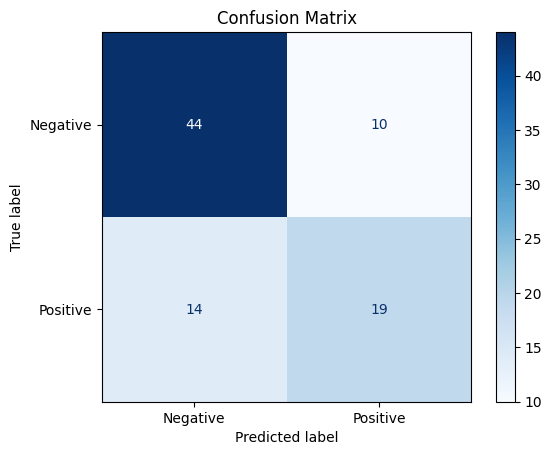


Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.79        54
    Positive       0.66      0.58      0.61        33

    accuracy                           0.72        87
   macro avg       0.71      0.70      0.70        87
weighted avg       0.72      0.72      0.72        87

Number of selected features: 75
Shape of SHAP values: (248, 75)


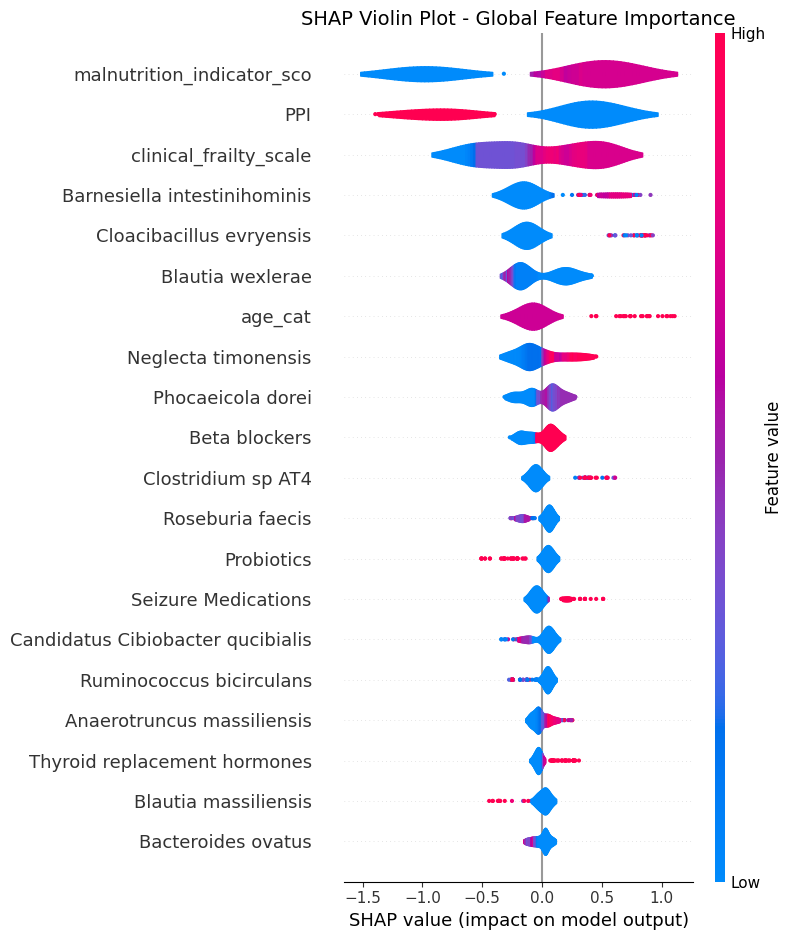

Overlap bacteria found: {'Clostridium_sp_AT4', 'Bariatricus_massiliensis', 'Negativibacillus_massiliensis', 'Lacrimispora_celerecrescens', 'GGB3005_SGB3996', 'Rikenellaceae_bacterium', 'Parabacteroides_merdae', 'Bifidobacterium_adolescentis', 'Neglecta_timonensis', 'Clostridia_bacterium', 'Ruminococcus_torques', 'Roseburia_inulinivorans', 'Enterocloster_lavalensis', 'GGB46116_SGB63877', 'Clostridium_sp_AF34_10BH', 'Bacteroides_ovatus', 'Eubacterium_rectale', 'Phascolarctobacterium_faecium', 'GGB9699_SGB15216', 'Anaerotruncus_massiliensis', 'Tyzzerella_nexilis', 'Faecalicatena_fissicatena', 'Phocaeicola_vulgatus', 'Faecalitalea_cylindroides', 'Blautia_massiliensis', 'Bacteroides_uniformis', 'Longibaculum_muris', 'Holdemania_sp_Marseille_P2844', 'Roseburia_faecis', 'GGB9712_SGB15244', 'GGB9602_SGB15031', 'Bacteroides_fragilis', 'Klebsiella_pneumoniae', 'Bacteroides_xylanisolvens', 'Firmicutes_bacterium_AF16_15', 'Bilophila_wadsworthia', 'GGB9347_SGB14313', 'Lachnospiraceae_bacterium_OM04

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.7962962962962963)

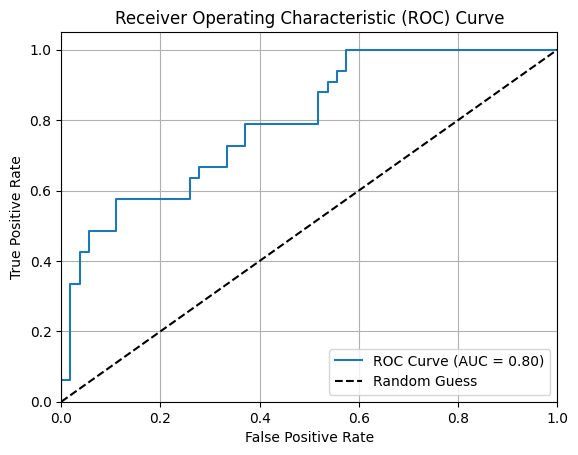

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.7241379310344828

In [18]:
f1

np.float64(0.6129032258064516)

In [19]:
conf_matrix

array([[44, 10],
       [14, 19]])

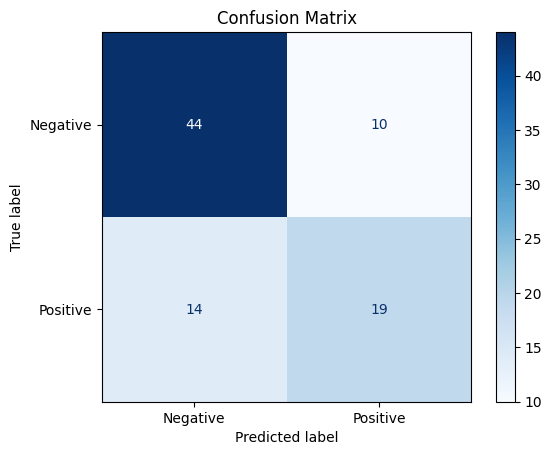

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

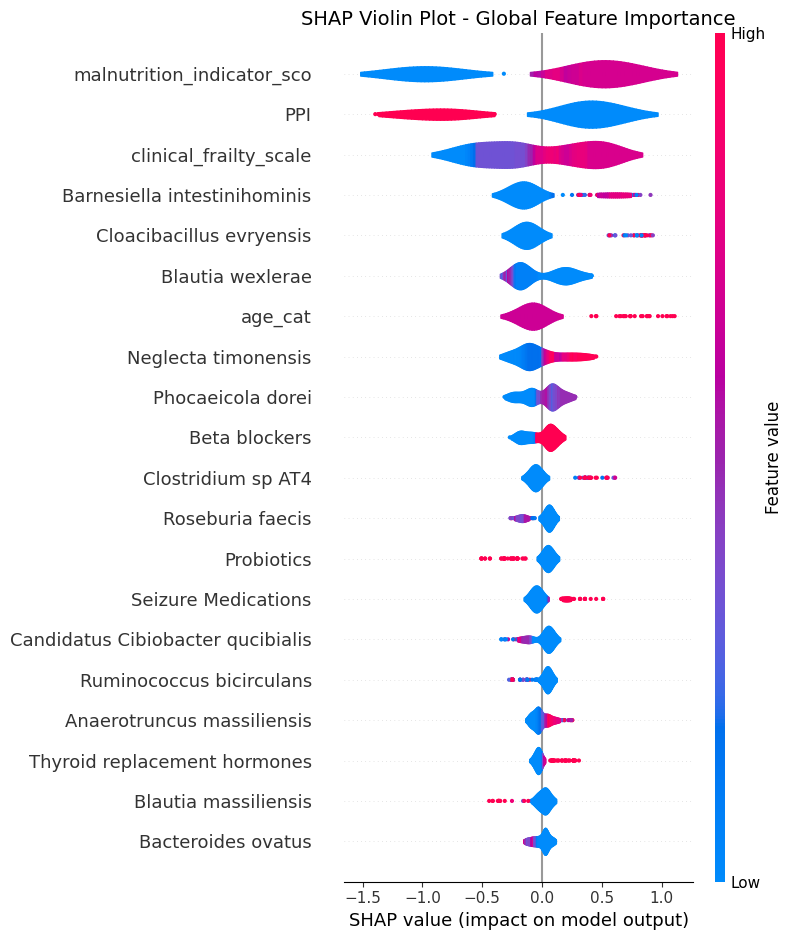

Overlap bacteria found: {'Clostridium_sp_AT4', 'Bariatricus_massiliensis', 'Negativibacillus_massiliensis', 'Lacrimispora_celerecrescens', 'GGB3005_SGB3996', 'Rikenellaceae_bacterium', 'Parabacteroides_merdae', 'Bifidobacterium_adolescentis', 'Neglecta_timonensis', 'Clostridia_bacterium', 'Ruminococcus_torques', 'Roseburia_inulinivorans', 'Enterocloster_lavalensis', 'GGB46116_SGB63877', 'Clostridium_sp_AF34_10BH', 'Bacteroides_ovatus', 'Eubacterium_rectale', 'Phascolarctobacterium_faecium', 'GGB9699_SGB15216', 'Anaerotruncus_massiliensis', 'Tyzzerella_nexilis', 'Faecalicatena_fissicatena', 'Phocaeicola_vulgatus', 'Faecalitalea_cylindroides', 'Blautia_massiliensis', 'Bacteroides_uniformis', 'Longibaculum_muris', 'Holdemania_sp_Marseille_P2844', 'Roseburia_faecis', 'GGB9712_SGB15244', 'GGB9602_SGB15031', 'Bacteroides_fragilis', 'Klebsiella_pneumoniae', 'Bacteroides_xylanisolvens', 'Firmicutes_bacterium_AF16_15', 'Bilophila_wadsworthia', 'GGB9347_SGB14313', 'Lachnospiraceae_bacterium_OM04

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (248, 75)


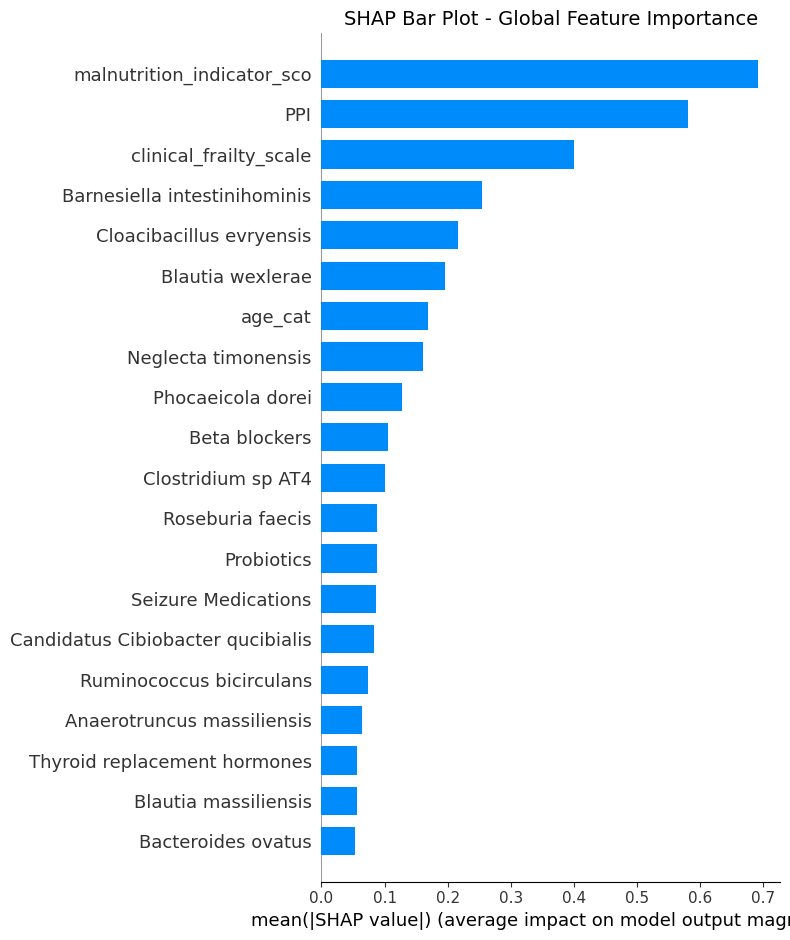

Overlap bacteria found: {'Clostridium_sp_AT4', 'Bariatricus_massiliensis', 'Negativibacillus_massiliensis', 'Lacrimispora_celerecrescens', 'GGB3005_SGB3996', 'Rikenellaceae_bacterium', 'Parabacteroides_merdae', 'Bifidobacterium_adolescentis', 'Neglecta_timonensis', 'Clostridia_bacterium', 'Ruminococcus_torques', 'Roseburia_inulinivorans', 'Enterocloster_lavalensis', 'GGB46116_SGB63877', 'Clostridium_sp_AF34_10BH', 'Bacteroides_ovatus', 'Eubacterium_rectale', 'Phascolarctobacterium_faecium', 'GGB9699_SGB15216', 'Anaerotruncus_massiliensis', 'Tyzzerella_nexilis', 'Faecalicatena_fissicatena', 'Phocaeicola_vulgatus', 'Faecalitalea_cylindroides', 'Blautia_massiliensis', 'Bacteroides_uniformis', 'Longibaculum_muris', 'Holdemania_sp_Marseille_P2844', 'Roseburia_faecis', 'GGB9712_SGB15244', 'GGB9602_SGB15031', 'Bacteroides_fragilis', 'Klebsiella_pneumoniae', 'Bacteroides_xylanisolvens', 'Firmicutes_bacterium_AF16_15', 'Bilophila_wadsworthia', 'GGB9347_SGB14313', 'Lachnospiraceae_bacterium_OM04

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1029933563,4,0.724138,0.796296,0.612903


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment04_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)